In [20]:
import pandas as pd
import numpy as np

# 1) LOAD YOUR DATA
portfolio = pd.read_csv("portfolio_companies.csv")
pe_funds  = pd.read_csv("pe_funds.csv")

# 2) MERGE & SELECT FEATURES → final_df
merged = portfolio.merge(
    pe_funds,
    left_on="PE Complete Name",
    right_on="PE_Name",
    how="left",
    suffixes=("", "_PE")
)

portfolio_cols = [
    "Target","Target HQ","PE","PE Complete Name",
    "PE HQ","Sector","Subsector","source_country_tab"
]
pe_cols = [
    "Sectors","Top Geographies","source_country_tab_PE",
    "Office in Spain (Y/N)"
]

final_df = (
    merged[portfolio_cols + pe_cols]
      .rename(columns={
         "source_country_tab_PE":     "source_country_tab_PE_fund",
         "PE Complete Name":          "investor_id"
      })
      .loc[lambda d: d["Office in Spain (Y/N)"].notnull()]
      .reset_index(drop=True)
)

# 3) POSITIVES
pos = final_df[["Target","investor_id"]].copy()
pos["invested"] = 1

# 4) NEGATIVES
all_investors = pe_funds["PE_Name"].unique()
rng = np.random.default_rng(42)
neg = pd.DataFrame([{
    "Target": comp,
    "investor_id": rng.choice([i for i in all_investors if i!=inv]),
    "invested": 0
} for comp,inv in zip(pos.Target, pos.investor_id)])

# 5) COMBINE & SHUFFLE
train = pd.concat([pos, neg], ignore_index=True) \
          .sample(frac=1, random_state=42) \
          .reset_index(drop=True)

print("Train shape:", train.shape)
print(train.invested.value_counts())


Train shape: (34546, 3)
invested
1    17273
0    17273
Name: count, dtype: int64


In [21]:
# 6) BUILD FEATURE LOOKUPS FROM THE ORIGINAL TABLES

# a) Company (portfolio) features
comp_feats = (
    portfolio[portfolio_cols]
    .drop_duplicates("Target")
    .set_index("Target")
)

# b) PE fund features – use the original source_country_tab
original_pe_cols = [
    "Sectors",
    "Top Geographies",
    "source_country_tab",
    "Office in Spain (Y/N)"
]
pe_feats = (
    pe_funds[["PE_Name"] + original_pe_cols]
    .rename(columns={
        "PE_Name": "investor_id",
        "source_country_tab": "source_country_tab_PE_fund"
    })
    .drop_duplicates("investor_id")
    .set_index("investor_id")
)

# 7) MERGE FEATURES ONTO train
train_enriched = (
    train
      # portfolio features by company
      .merge(comp_feats,    left_on="Target",      right_index=True, how="left")
      # fund features by investor_id
      .merge(pe_feats,      left_on="investor_id", right_index=True, how="left")
)

# 8) SELECT & ORDER COLUMNS
portfolio_cols_final = [
    "Target","Target HQ","PE","investor_id",
    "PE HQ","Sector","Subsector","source_country_tab"
]
pe_cols_final = [
    "Sectors","Top Geographies",
    "source_country_tab_PE_fund","Office in Spain (Y/N)"
]

train_final = train_enriched[portfolio_cols_final + pe_cols_final + ["invested"]].reset_index(drop=True)

# 9) SANITY‐CHECK
print("Final train shape:", train_final.shape)
print(train_final.columns.tolist())
print(train_final["invested"].value_counts())


Final train shape: (34546, 13)
['Target', 'Target HQ', 'PE', 'investor_id', 'PE HQ', 'Sector', 'Subsector', 'source_country_tab', 'Sectors', 'Top Geographies', 'source_country_tab_PE_fund', 'Office in Spain (Y/N)', 'invested']
invested
1    17273
0    17273
Name: count, dtype: int64


In [22]:
train_final[train_final["invested"] == 0]

,Target,Target HQ,PE,investor_id,PE HQ,Sector,Subsector,source_country_tab,Sectors,Top Geographies,source_country_tab_PE_fund,Office in Spain (Y/N),invested
1,MAAX Inc,Canada,Lone Star Global Acquisitions Ltd,Atalante SAS,USA,Construction,"Hardware and plumbing supplies,Other lightside...",USA,"Services (other), Computer software, Industria...","France, Spain, Italy, Belgium, Greece",France_PE,Y,0
2,Pictage Inc,USA,Apax Partners LLP,Queka Real Partners,NaN,Internet / ecommerce,"Business support services,Publishing",UK,Generalist,Spain,Spain_PE,Y,0
4,Windstream Nuvox LLC,USA,KKR & Co Inc,Ardian France SA,USA,Internet / ecommerce,"Fixed line telecoms,Mobile/satellite telecoms ...",USA,"Computer software, Services (other), Industria...","France, Italy, Germany, Spain, USA",France_PE,Y,0
6,"Derprosa, S.A.",Spain,Baring Private Equity Partners Espana SA,TCMI Inc,Spain,Manufacturing (other),Packaging products and systems,Spain,"Computer software, Internet / ecommerce, Media...","USA, United Kingdom, Canada, Germany, France",USA_PE,N,0
7,REPA Holding GmbH (100.00% stake),Germany,Riverside Co,Paine Schwartz Partners LLC,USA,Services (other),"Importers and wholesalers,Industrial equipment...",USA,"Agriculture, Consumer: Foods, Industrial produ...","USA, Australia, Netherlands, United Kingdom, B...",USA_PE,N,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34530,Rolland Enterprises Inc.,Canada,HIG Capital LLC,InfraVia Capital Partners,USA,Manufacturing (other),Pulp and paper,USA,"Energy, Computer software, Transportation, Com...","France, Spain, Italy, Ireland, Netherlands",France_PE,N,0
34532,TScan Therapeutics Inc,USA,Bessemer Venture Partners - BVP,Zetland Capital Partners LLP,USA,Medical: Pharmaceuticals,Drug development,USA,"Consumer: Retail, Leisure, Internet / ecommerce","United Kingdom, Spain, France, Germany, Italy",UK_PE,N,0
34533,Dedalus Holding S.p.A.,Italy,Ardian France SA,Apollo Global Management Inc,France,NaN,Computer software,France,"Financial Services, Energy, Leisure, Industria...","USA, United Kingdom, Germany, India, Canada",USA_PE,N,0
34534,"Urkabe Benetan, S.A.",Spain,Stellum Capital,Trilantic Europe Sarl,Spain,Food Industry (Processed Meat),Meat Processing,Spain,"Leisure, Medical, Services (other), Computer s...","USA, United Kingdom, Spain",UK_PE,Y,0


In [23]:
train_final.columns.tolist()

['Target',
 'Target HQ',
 'PE',
 'investor_id',
 'PE HQ',
 'Sector',
 'Subsector',
 'source_country_tab',
 'Sectors',
 'Top Geographies',
 'source_country_tab_PE_fund',
 'Office in Spain (Y/N)',
 'invested']

In [24]:
train_final[train_final['Sector'].isnull()]

,Target,Target HQ,PE,investor_id,PE HQ,Sector,Subsector,source_country_tab,Sectors,Top Geographies,source_country_tab_PE_fund,Office in Spain (Y/N),invested
9,Brown Europe SASU (100.00% stake),France,Tikehau Capital SCA,KKR & Co Inc,France,NaN,Industrial products and services,France,"Computer software, Financial Services, Energy,...","USA, United Kingdom, India, Germany, Spain",USA_PE,Y,0
11,Perstorp Holding AB (100.00% stake),Sweden,PAI Partners SAS,PAI Partners SAS,France,NaN,Chemicals and materials,France,"Consumer: Foods, Services (other), Consumer: R...","France, UK, Germany, Spain, Italy",France_PE,Y,1
20,Novuspharma SpA,Italy,Sofinnova Partners SAS,Sofinnova Partners SAS,France,NaN,Biotechnology,France,"Biotechnology, Medical: Pharmaceuticals, Medic...","France, USA, UK, Switzerland, Italy",France_PE,N,1
42,Spodis SA,France,Sigefi Private Equity,Qualitas Equity Partners,France,NaN,Consumer: Retail,France,"Energy, Software, Chemicals, E-commerce, Const...","Spain, Germany, Italy, USA, Sweden",Spain_PE,Y,0
45,Siaci Saint Honore SAS,France,Ardian France SA,Espiga Capital,France,NaN,Financial Services,France,"Industrial Products, Manufacturing, Chemicals,...",Spain,Spain_PE,Y,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34475,Duplomatic MS SpA,Italy,Ardian France SA,Ardian France SA,France,NaN,Industrial products and services,France,"Computer software, Services (other), Industria...","France, Italy, Germany, Spain, USA",France_PE,Y,1
34509,Averys SAS,France,Ardian France SA,Ardian France SA,France,NaN,Industrial products and services,France,"Computer software, Services (other), Industria...","France, Italy, Germany, Spain, USA",France_PE,Y,1
34526,Gruppo Investimenti Portuali SpA,Italy,InfraVia Capital Partners,InfraVia Capital Partners,France,NaN,Transportation,France,"Energy, Computer software, Transportation, Com...","France, Spain, Italy, Ireland, Netherlands",France_PE,N,1
34533,Dedalus Holding S.p.A.,Italy,Ardian France SA,Apollo Global Management Inc,France,NaN,Computer software,France,"Financial Services, Energy, Leisure, Industria...","USA, United Kingdom, Germany, India, Canada",USA_PE,N,0


In [25]:
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# ⚙️ 0) Download required NLTK data
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

# 1) Setup
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

# 2) Cleaner + noun-only lemmatizer
def clean_text(text):
    txt = str(text).lower()
    txt = re.sub(r"[^a-z0-9\s]", " ", txt)
    tokens = [w for w in txt.split() if w.isalpha() and w not in stop_words]
    # noun-only lemmatization via default wordnet.NOUN
    return " ".join(lemmatizer.lemmatize(w, wordnet.NOUN) for w in tokens if len(w)>1)

# 3) Apply to each column
cols = ["Sector","Subsector","Sectors","Top Geographies"]
for c in cols:
    train_final[f"NLP_{c}"] = train_final[c].fillna("").apply(clean_text)

# 4) TF-IDF vectorization per column
for c in cols:
    key = f"NLP_{c}"
    tfv = TfidfVectorizer(max_features=100)
    mat = tfv.fit_transform(train_final[key]).toarray()
    tfdf = pd.DataFrame(
        mat,
        columns=[f"TFIDF_{c}_{i}" for i in range(mat.shape[1])]
    )
    train_final = pd.concat([train_final, tfdf], axis=1)

print("After TF-IDF:", train_final.shape)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


After TF-IDF: (34546, 348)


In [26]:
# Uninstall whatever’s broken, then pin to known-compatible versions
#!pip install --quiet --upgrade \
 #   numpy==1.23.5 \
 #   gensim==4.3.2


In [27]:
# ─── Block B (patched) ────────────────────────────────────────

#import numpy as np
#import scipy.linalg as spla

# Monkey-patch scipy.linalg.triu → use numpy’s triu
#spla.triu = np.triu

# Now gensim can import without triu errors
#from gensim.models import Word2Vec

# Your existing code follows:

# 1) Tokenize cleaned text
#cols = ["Sector","Subsector","Sectors","Top Geographies"]
#tokenized = {c: train_final[f"NLP_{c}"].str.split() for c in cols}

# 2) Train Word2Vec on all sentences
#all_sentences = [sent for lst in tokenized.values() for sent in lst]
#w2v = Word2Vec(
 #   sentences=all_sentences,
 #   vector_size=50,
 #   window=5,
 #   min_count=1,
 #   workers=4,
 #   seed=42
#)

# 3) Averaging helper
#def avg_vec(tokens):
 #   vs = [w2v.wv[w] for w in tokens if w in w2v.wv]
 #   return np.mean(vs, axis=0) if vs else np.zeros(50)

# 4) Build & concat W2V features
#for c in cols:
 #   mat = np.vstack(
 #       train_final[f"NLP_{c}"].str.split().apply(avg_vec).values
 #   )
 #   w2v_df = pd.DataFrame(
 #       mat,
 #       columns=[f"W2V_{c}_{i}" for i in range(50)]
 #   )
 #   train_final = pd.concat([train_final, w2v_df], axis=1)

#print("After Word2Vec:", train_final.shape)


In [28]:
print("Shape:", train_final.shape)
print(train_final.dtypes.value_counts())
train_final.head()


Shape: (34546, 348)
float64    331
object      16
int64        1
Name: count, dtype: int64


,Target,Target HQ,PE,investor_id,PE HQ,Sector,Subsector,source_country_tab,Sectors,Top Geographies,...,TFIDF_Top Geographies_47,TFIDF_Top Geographies_48,TFIDF_Top Geographies_49,TFIDF_Top Geographies_50,TFIDF_Top Geographies_51,TFIDF_Top Geographies_52,TFIDF_Top Geographies_53,TFIDF_Top Geographies_54,TFIDF_Top Geographies_55,TFIDF_Top Geographies_56
0,Potter Electric Signal Co LLC (100.00% stake),USA,KKR & Co Inc,KKR & Co Inc,USA,Telecommunications: Hardware,"Industrial equipment and machinery,Security & ...",USA,"Computer software, Financial Services, Energy,...","USA, United Kingdom, India, Germany, Spain",...,0.391029,0.0,0.0,0.0,0.0,0.340271,0.319795,0.0,0.0,0.0
1,MAAX Inc,Canada,Lone Star Global Acquisitions Ltd,Atalante SAS,USA,Construction,"Hardware and plumbing supplies,Other lightside...",USA,"Services (other), Computer software, Industria...","France, Spain, Italy, Belgium, Greece",...,0.234965,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2,Pictage Inc,USA,Apax Partners LLP,Queka Real Partners,NaN,Internet / ecommerce,"Business support services,Publishing",UK,Generalist,Spain,...,1.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
3,International Data Group Inc,USA,Blackstone Inc,Blackstone Inc,USA,Media,"Advertising,Business support services,Consulti...",USA,"Real Estate, Computer software, Leisure, Finan...","USA, United Kingdom, India, Germany, France",...,0.000000,0.0,0.0,0.0,0.0,0.338540,0.318168,0.0,0.0,0.0
4,Windstream Nuvox LLC,USA,KKR & Co Inc,Ardian France SA,USA,Internet / ecommerce,"Fixed line telecoms,Mobile/satellite telecoms ...",USA,"Computer software, Services (other), Industria...","France, Italy, Germany, Spain, USA",...,0.424298,0.0,0.0,0.0,0.0,0.000000,0.347003,0.0,0.0,0.0


In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report

# 1) One-hot–encode the metadata
cat_cols = [
    'Target HQ',
    'PE HQ',
    'source_country_tab',
    'source_country_tab_PE_fund',
    'Office in Spain (Y/N)'
]
X_cat = pd.get_dummies(train_final[cat_cols], drop_first=True)

# 2) Grab all TF-IDF columns
X_tfidf = train_final.filter(regex=r"^TFIDF_")

# 3) Combine into a single feature matrix
X = pd.concat([X_tfidf, X_cat], axis=1)

# 4) Define your target
y = train_final['invested']

# 5) Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 6) Train XGBoost
model = XGBClassifier(eval_metric="logloss", random_state=42)

model.fit(X_train, y_train)

# 7) Evaluate
probs = model.predict_proba(X_test)[:,1]
print("ROC AUC:", roc_auc_score(y_test, probs))
print("\nClassification report @0.5:\n", classification_report(
    y_test, (probs>=0.5).astype(int)
))


ROC AUC: 0.948731949543542

Classification report @0.5:
               precision    recall  f1-score   support

           0       0.93      0.85      0.89      3455
           1       0.86      0.94      0.90      3455

    accuracy                           0.89      6910
   macro avg       0.90      0.89      0.89      6910
weighted avg       0.90      0.89      0.89      6910



In [30]:
import pandas as pd
import joblib
from xgboost import XGBClassifier

# Assemble your final feature matrix & label
cat_cols = [
    'Target HQ',
    'PE HQ',
    'source_country_tab',
    'source_country_tab_PE_fund',
    'Office in Spain (Y/N)'
]
X_cat = pd.get_dummies(train_final[cat_cols], drop_first=True)
X_tfidf = train_final.filter(regex=r"^TFIDF_")
X = pd.concat([X_tfidf, X_cat], axis=1)
y = train_final['invested']

# Train on all data
final_model = XGBClassifier(eval_metric='logloss', random_state=42)
final_model.fit(X, y)

# Save model and metadata for inference
joblib.dump(final_model, 'xgb_full_model.joblib')
joblib.dump(X.columns.tolist(), 'feature_columns.joblib')
joblib.dump(cat_cols, 'categorical_columns.joblib')

print("Model and feature metadata saved to disk.")


Model and feature metadata saved to disk.


In [31]:
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer

# 1) Re-fit & collect your TFIDF vectorizers
tfidf_vectorizers = {}
for col in ["Sector","Subsector","Sectors","Top Geographies"]:
    key = f"NLP_{col}"
    vect = TfidfVectorizer(max_features=100)
    vect.fit(train_final[key])                     # fit on the cleaned text
    tfidf_vectorizers[col] = vect

# 2) Save the dict of vectorizers
joblib.dump(tfidf_vectorizers, "tfidf_vectorizers.joblib")
print("✅ Saved TF-IDF vectorizers to tfidf_vectorizers.joblib")

# 3) (Optional) export the TF-IDF features themselves
tfidf_feats = train_final.filter(regex="^TFIDF_")
tfidf_feats.to_csv("tfidf_features.csv", index=False)
print("✅ Exported TF-IDF feature matrix to tfidf_features.csv")


✅ Saved TF-IDF vectorizers to tfidf_vectorizers.joblib
✅ Exported TF-IDF feature matrix to tfidf_features.csv


**Deep Learning multi categorical outcome **

In [34]:
# 1) (Re)load your train/val splits and LabelEncoder
import joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# assume you already have `train_final` DataFrame from previous steps
# and that you saved your TF-IDF + cat feature matrices as X, and y_raw as investor_id strings:

# e.g. if you didn't already:
X_tfidf = train_final.filter(regex="^TFIDF_")
X_cat   = pd.get_dummies(train_final[cat_cols], drop_first=True)
X = pd.concat([X_tfidf, X_cat], axis=1)
y_raw = train_final["investor_id"]

# 1.1) Integer‐encode the investor labels

# 1) Grab the full list of potential investors:
all_investors = pe_funds["PE_Name"].unique()

# 2) Fit the encoder on that full list:
le = LabelEncoder()
le.fit(all_investors)              # now le.classes_ == every fund in pe_funds

# 3) Transform only your actual training labels:
y = le.transform(y_raw)            # y_raw is the investor_id column from your pos/neg samples

# 4) Book‐keep how many total classes you have:
num_classes = len(le.classes_)
print(f"{num_classes} total investors in universe.")

# 1.2) Train/val split
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)
print("X_train:", X_train.shape, "X_val:", X_val.shape)

# 1.3) Persist the encoder for later
joblib.dump(le, "investor_label_encoder.joblib")


169 total investors in universe.
X_train: (27636, 727) X_val: (6910, 727)


['investor_label_encoder.joblib']

In [35]:
# 2) Install if needed: !pip install --quiet tensorflow

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 2.1) Define the network
model = Sequential([
    Dense(512, activation="relu", input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(256, activation="relu"),
    Dropout(0.3),
    Dense(num_classes, activation="softmax"),
])

# 2.2) Compile
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 512)            │       372,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 169)            │        43,433 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 547,497 (2.09 MB)

 Trainable params: 547,497 (2.09 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# 3) Train
es = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=128,
    callbacks=[es],
    verbose=2
)


Epoch 1/20
216/216 - 4s - 20ms/step - accuracy: 0.5866 - loss: 2.0177 - val_accuracy: 0.9478 - val_loss: 0.2107
Epoch 2/20
216/216 - 6s - 28ms/step - accuracy: 0.9429 - loss: 0.2087 - val_accuracy: 0.9505 - val_loss: 0.1258
Epoch 3/20
216/216 - 4s - 18ms/step - accuracy: 0.9523 - loss: 0.1423 - val_accuracy: 0.9499 - val_loss: 0.1216
Epoch 4/20
216/216 - 3s - 14ms/step - accuracy: 0.9540 - loss: 0.1259 - val_accuracy: 0.9511 - val_loss: 0.1206
Epoch 5/20
216/216 - 6s - 29ms/step - accuracy: 0.9554 - loss: 0.1174 - val_accuracy: 0.9507 - val_loss: 0.1194
Epoch 6/20
216/216 - 4s - 19ms/step - accuracy: 0.9559 - loss: 0.1147 - val_accuracy: 0.9525 - val_loss: 0.1175
Epoch 7/20
216/216 - 3s - 14ms/step - accuracy: 0.9586 - loss: 0.1085 - val_accuracy: 0.9504 - val_loss: 0.1233
Epoch 8/20
216/216 - 3s - 16ms/step - accuracy: 0.9606 - loss: 0.1043 - val_accuracy: 0.9504 - val_loss: 0.1258
Epoch 9/20
216/216 - 4s - 16ms/step - accuracy: 0.9617 - loss: 0.1009 - val_accuracy: 0.9504 - val_loss:

Validation accuracy: 0.9525


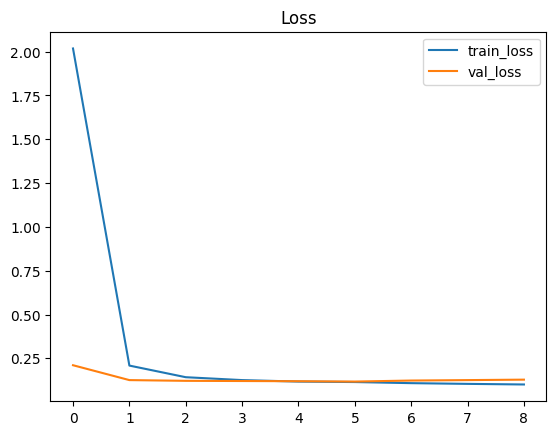

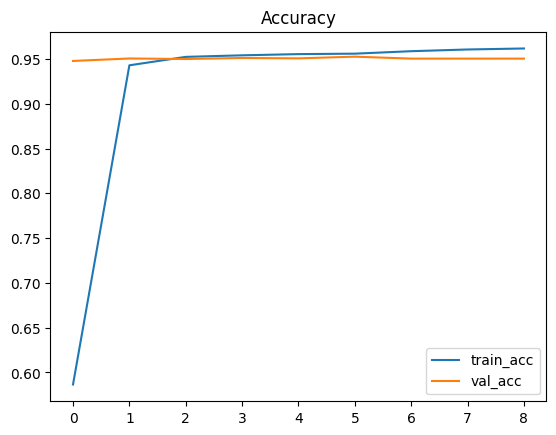

In [37]:
# 4) Evaluate
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation accuracy: {val_acc:.4f}")

# 5) Save the trained model (native Keras format, required extension)
model.save("investor_classifier_tf.keras")

# 6) (Optional) Plot training curves
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.legend()
plt.title("Accuracy")
plt.show()


In [38]:
#from google.colab import drive
#drive.mount('/content/drive')


Mounted at /content/drive


In [40]:
# Create a target folder in your Drive (if not done yet)
!mkdir -p /content/drive/MyDrive/NLP_Project

# Move each file
!mv investor_label_encoder.joblib /content/drive/MyDrive/NLP_Project/
